In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import bz2
import corner
import h5py
import pickle
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.integrate import cumtrapz
import scipy.stats as ss
import seaborn as sns
import sys
from true_params import true_params, uncert
import tqdm

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [3]:
d = '/Users/wfarr/Code/pydelfi'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
from pydelfi import ndes
from pydelfi import delfi
from pydelfi import score
from pydelfi import priors
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
with h5py.File('thetas.h5', 'r') as f:
    thetas = array(f['Theta'])
thetas = sort(concatenate((thetas, [0,1])))
ticum = interp1d(linspace(0, 1, len(thetas)), thetas)

with h5py.File('optimal_snr.h5', 'r') as f:
    ms = array(f['ms'])
    rhos = array(f['SNR'])
oint = RectBivariateSpline(ms, ms, rhos)

In [5]:
oint.ev(array([1,2,3]), array([2,3,4]))

array([3.39704894, 5.34188423, 7.06473383])

In [6]:
def draw_m1_m2(N, alpha, beta, MMin, MMax, smin, smax):
    ms = exp(linspace(log(MMin)-7*smin, log(MMax) + 7*smax, 1000))
    pm1 = ms**(-alpha)*ss.norm(loc=log(MMin), scale=smin).cdf(log(ms))*(1-ss.norm(loc=log(MMax), scale=smax).cdf(log(ms)))
    pm2 = ms**(beta)*ss.norm(loc=log(MMin), scale=smin).cdf(log(ms))*(1-ss.norm(loc=log(MMax), scale=smax).cdf(log(ms)))
    
    cm1 = cumtrapz(pm1, ms, initial=0)
    cm2 = cumtrapz(pm2, ms, initial=0)
    
    cm1 /= cm1[-1]
    cm2 /= cm2[-1]
    
    icm1 = interp1d(cm1, ms)
    icm2 = interp1d(cm2, ms)
    
    m1s = []
    m2s = []
    while len(m1s) < N:
        m1 = icm1(rand(N))
        m2 = icm2(rand(N))
        
        s = m2 <= m1
        
        m1s = np.concatenate((m1s, m1[s]))
        m2s = np.concatenate((m2s, m2[s]))
        
    m1s = m1s[:N]
    m2s = m2s[:N]
    
    return (m1s, m2s)
    
def draw_z(R0, g, H0, Om, w, zmax):
    zs = expm1(linspace(log(1), log(1+zmax), 1000))
    c = cosmo.wCDM(H0*u.km/u.s/u.Mpc, Om, 1.0-Om, w)
    dNdz = R0*4.0*pi*c.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**(g-1)
    N = trapz(dNdz, zs)
    zcum = cumtrapz(dNdz, zs, initial=0)
    
    icum = interp1d(zcum, zs)
    
    n = random.poisson(N)
    return icum(N*rand(n))

def mc_eta_from_m1m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    mc = mt*eta**(0.6)
    return mc, eta

def m1m2_from_mc_eta(mc, eta):
    mt = mc/eta**(0.6)
    
    disc = 1-4*eta
    sd = sqrt(disc)
    m1 = 0.5*mt*(1+sd)
    m2 = 0.5*mt*(1-sd)
    return m1, m2

def draw(R0, MMin, MMax, smin, smax, alpha, beta, gamma, H0, Om, w):
    zmax = 3 # at z = 3, 50-50 in source frame is SNR ~ 5, so rare.
    ztrue = draw_z(R0, gamma, H0, Om, w, 3)
    ctrue = cosmo.wCDM(H0*u.km/u.s/u.Mpc, Om, 1-Om, w)
    dltrue = ctrue.luminosity_distance(ztrue).to(u.Gpc).value
    m1true, m2true = draw_m1_m2(len(ztrue), alpha, beta, MMin, MMax, smin, smax) 
    m1trueobs = m1true*(1+ztrue)
    m2trueobs = m2true*(1+ztrue)
    thetatrue = ticum(rand(len(m1trueobs)))
    
    rhotrue = thetatrue*oint.ev(m1trueobs, m2trueobs)/dltrue
    
    rhoobs = rhotrue + randn(len(rhotrue))
    
    sel = rhoobs > 8
    
    ztrue = ztrue[sel]
    dltrue = dltrue[sel]
    m1true = m1true[sel]
    m2true = m2true[sel]
    m1trueobs = m1trueobs[sel]
    m2trueobs = m2trueobs[sel]
    rhotrue = rhotrue[sel]
    thetatrue = thetatrue[sel]
    rhoobs = rhoobs[sel]
    
    mctrueobs, etatrue = mc_eta_from_m1m2(m1trueobs, m2trueobs)
    
    smc = abs(uncert['threshold_snr']/rhoobs*0.05)
    mcobs = random.lognormal(mean=log(mctrueobs), sigma=smc)
    
    se = abs(uncert['threshold_snr']/rhoobs*uncert['eta'])
    etobs = etatrue + se*randn(len(se))
    while np.any(etobs > 0.25) or np.any(etobs < 0):
        s = (etobs > 0.25) | (etobs < 0)
        etobs[s] = etatrue[s] + se[s]*randn(len(se[s]))
    
    m1obs, m2obs = m1m2_from_mc_eta(mcobs, etobs)

    st = abs(uncert['threshold_snr']/rhoobs*uncert['Theta'])
    thetaobs = thetatrue + st*randn(len(st))
    while np.any(thetaobs < 0) or np.any(thetaobs > 1):
        s = (thetaobs < 0) | (thetaobs > 1)
        thetaobs[s] = thetatrue[s] + st[s]*randn(len(st[s]))
    
    dlobs = thetaobs*oint.ev(m1obs, m2obs)/rhoobs
    
    return m1obs, m2obs, dlobs, thetaobs

Number after 1 year = 1061


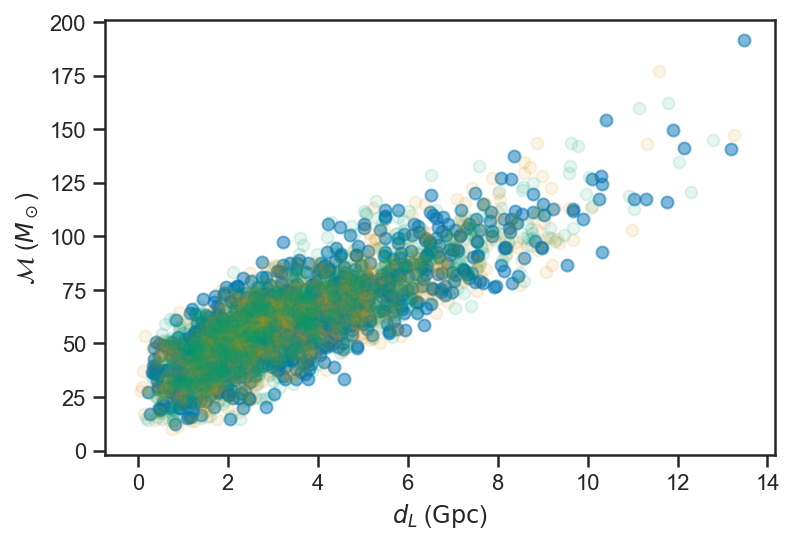

In [7]:
R0 = true_params['R0']
MMin = true_params['MMin']
MMax = true_params['MMax']
dc = 0.5
alpha = true_params['alpha']
beta = true_params['beta']
gamma = true_params['gamma']
smin = true_params['smooth_min']
smax = true_params['smooth_max']
H0 = true_params['H0']
Om = true_params['Om']
w = true_params['w']

m1, m2, dl, t = draw(dc*R0, MMin, MMax, smin, smax, alpha, beta, gamma, H0, Om, w)

print('Number after 1 year = {:d}'.format(len(m1)))
scatter(dl, m1, alpha=0.5)

ylabel(r'$\mathcal{M}$ ($M_\odot$)')
xlabel(r'$d_L$ ($\mathrm{Gpc}$)')

m1, m2, dl, t = draw(dc*R0, MMin, MMax, smin, smax, alpha, beta, gamma, H0, Om, w - 0.1)
scatter(dl, m1, alpha=0.1)

m1, m2, dl, t = draw(dc*R0, MMin, MMax, smin, smax, alpha, beta, gamma, H0, Om, w + 0.1)
scatter(dl, m1, alpha=0.1)

In [8]:
def m1_dl_to_summary(m1, dl):
    bins = sort(concatenate((percentile(dl, [10, 20, 30, 40, 50, 60, 70, 80, 90]), [0.0, 1.01*np.max(dl)])))
    cent = 0.5*(bins[1:]+bins[:-1])
    
    ds = []
    mm = []
    for l, h in zip(bins[:-1], bins[1:]):
        s = (l <= dl) & (dl < h)
        ds.append(median(dl[s]))
        mm.append(np.percentile(m1[s], 90))
    
    return len(m1), array(ds), array(mm)

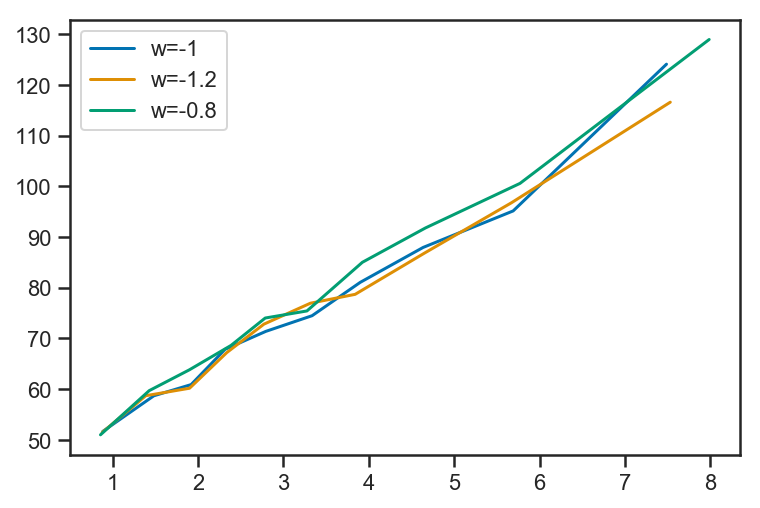

In [9]:
m1, m2, dl, t = draw(dc*R0, MMin, MMax, smin, smax, alpha, beta, gamma, H0, Om, w)
_, c, m = m1_dl_to_summary(m1, dl)
l, = plot(c, m, label='w=-1')

m1, m2, dl, t = draw(dc*R0, MMin, MMax, smin, smax, alpha, beta, gamma, H0, Om, w-0.2)
_, c, m = m1_dl_to_summary(m1, dl)
l, = plot(c, m, label='w=-1.2')

m1, m2, dl, t = draw(dc*R0, MMin, MMax, smin, smax, alpha, beta, gamma, H0, Om, w+0.2)
n, c, m = m1_dl_to_summary(m1, dl)
l, = plot(c, m, label='w=-0.8')

legend(loc='best')

We want to impose cosmological constraints, so we imagine a 1% measurement of H0 and Omh2, and transform back to H0 and Om.

In [10]:
h0 = H0/100.0

Covhomh2 = diag([(0.01*H0)**2, (0.01*Om*h0**2)**2])
J = array([[1.0, 0.0], [2.0*Om*h0/100.0, h0**2]])# d(H0, Omh2)/d(H0, Om)
Jinv = np.linalg.inv(J)
Covhom = np.dot(Jinv.T, np.dot(Covhomh2, Jinv))

In [11]:
# Parameter order is H0, Om, w
prior_mean = array([H0, Om, w])
prior_cov = np.diag([15**2, 0.15**2, 0.5**2])
#prior_cov[-3:-1, -3:-1] = Covhom # Implement the cosmological constraints
lower = array([55.0, 0.05, -2.0])
upper = array([95.0, 0.75, 0.0])
prior = priors.TruncatedGaussian(prior_mean, prior_cov, lower, upper)

In [12]:
theta_fiducial = prior_mean

def simulator(theta, seed=None, simulator_args=None, batch=None):
    rst = random.get_state()
    random.seed(seed)
    try:
        H0, Om, w = theta
        m1, m2, dl, t = draw(dc*R0, MMin, MMax, smin, smax, alpha, beta, gamma, H0, Om, w)
        n, c, m = m1_dl_to_summary(m1, dl)
    finally:
        random.set_state(rst)
    
    return concatenate(([n], c, m))

nd = len(simulator(theta_fiducial, None, None, 1))

compressor = score.Gaussian(nd, theta_fiducial, prior_mean=prior_mean, prior_covariance=prior_cov)

In [13]:
compressor.compute_mean_covariance(simulator, 128)

In [15]:
compressor.compute_derivatives(simulator, 8, 0.1*sqrt(diag(prior_cov)))

In [16]:
compressor.compute_fisher()

In [17]:
def compress(d, compres_args):
    return compressor.scoreMLE(d)

In [18]:
with bz2.BZ2File('LFI/compressor.pkl.bz2', 'w') as f:
    pickle.dump(compressor, f)

Execute the below to re-load the compressor:

In [19]:
with bz2.BZ2File('LFI/compressor.pkl.bz2', 'r') as f:
    compressor = pickle.load(f)

In [20]:
d0 = simulator(prior_mean, None, None, 1)
t0 = compress(d0, None)
t0

array([67.77016728,  0.30578361, -0.98352308])

In [21]:
npar = 3
ndat = 3
i = 0
NDEs = [ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndat, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=i),
       ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndat, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=i+1),
       ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndat, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=i+2),
       ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndat, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=i+3),
       ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndat, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=i+4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=npar, n_data=ndat, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=i+5)]

DelfiEnsemble = delfi.Delfi(t0, prior, NDEs, Finv=compressor.Finv, theta_fiducial=prior_mean, 
                       param_limits = [lower, upper],
                       param_names = [r'H_0', r'\Omega_M', r'w'],
                       results_dir = "./LFI/",
                       input_normalization="fisher")

/Users/wfarr/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Sampling approximate posterior...
Done.
Removed no burn in


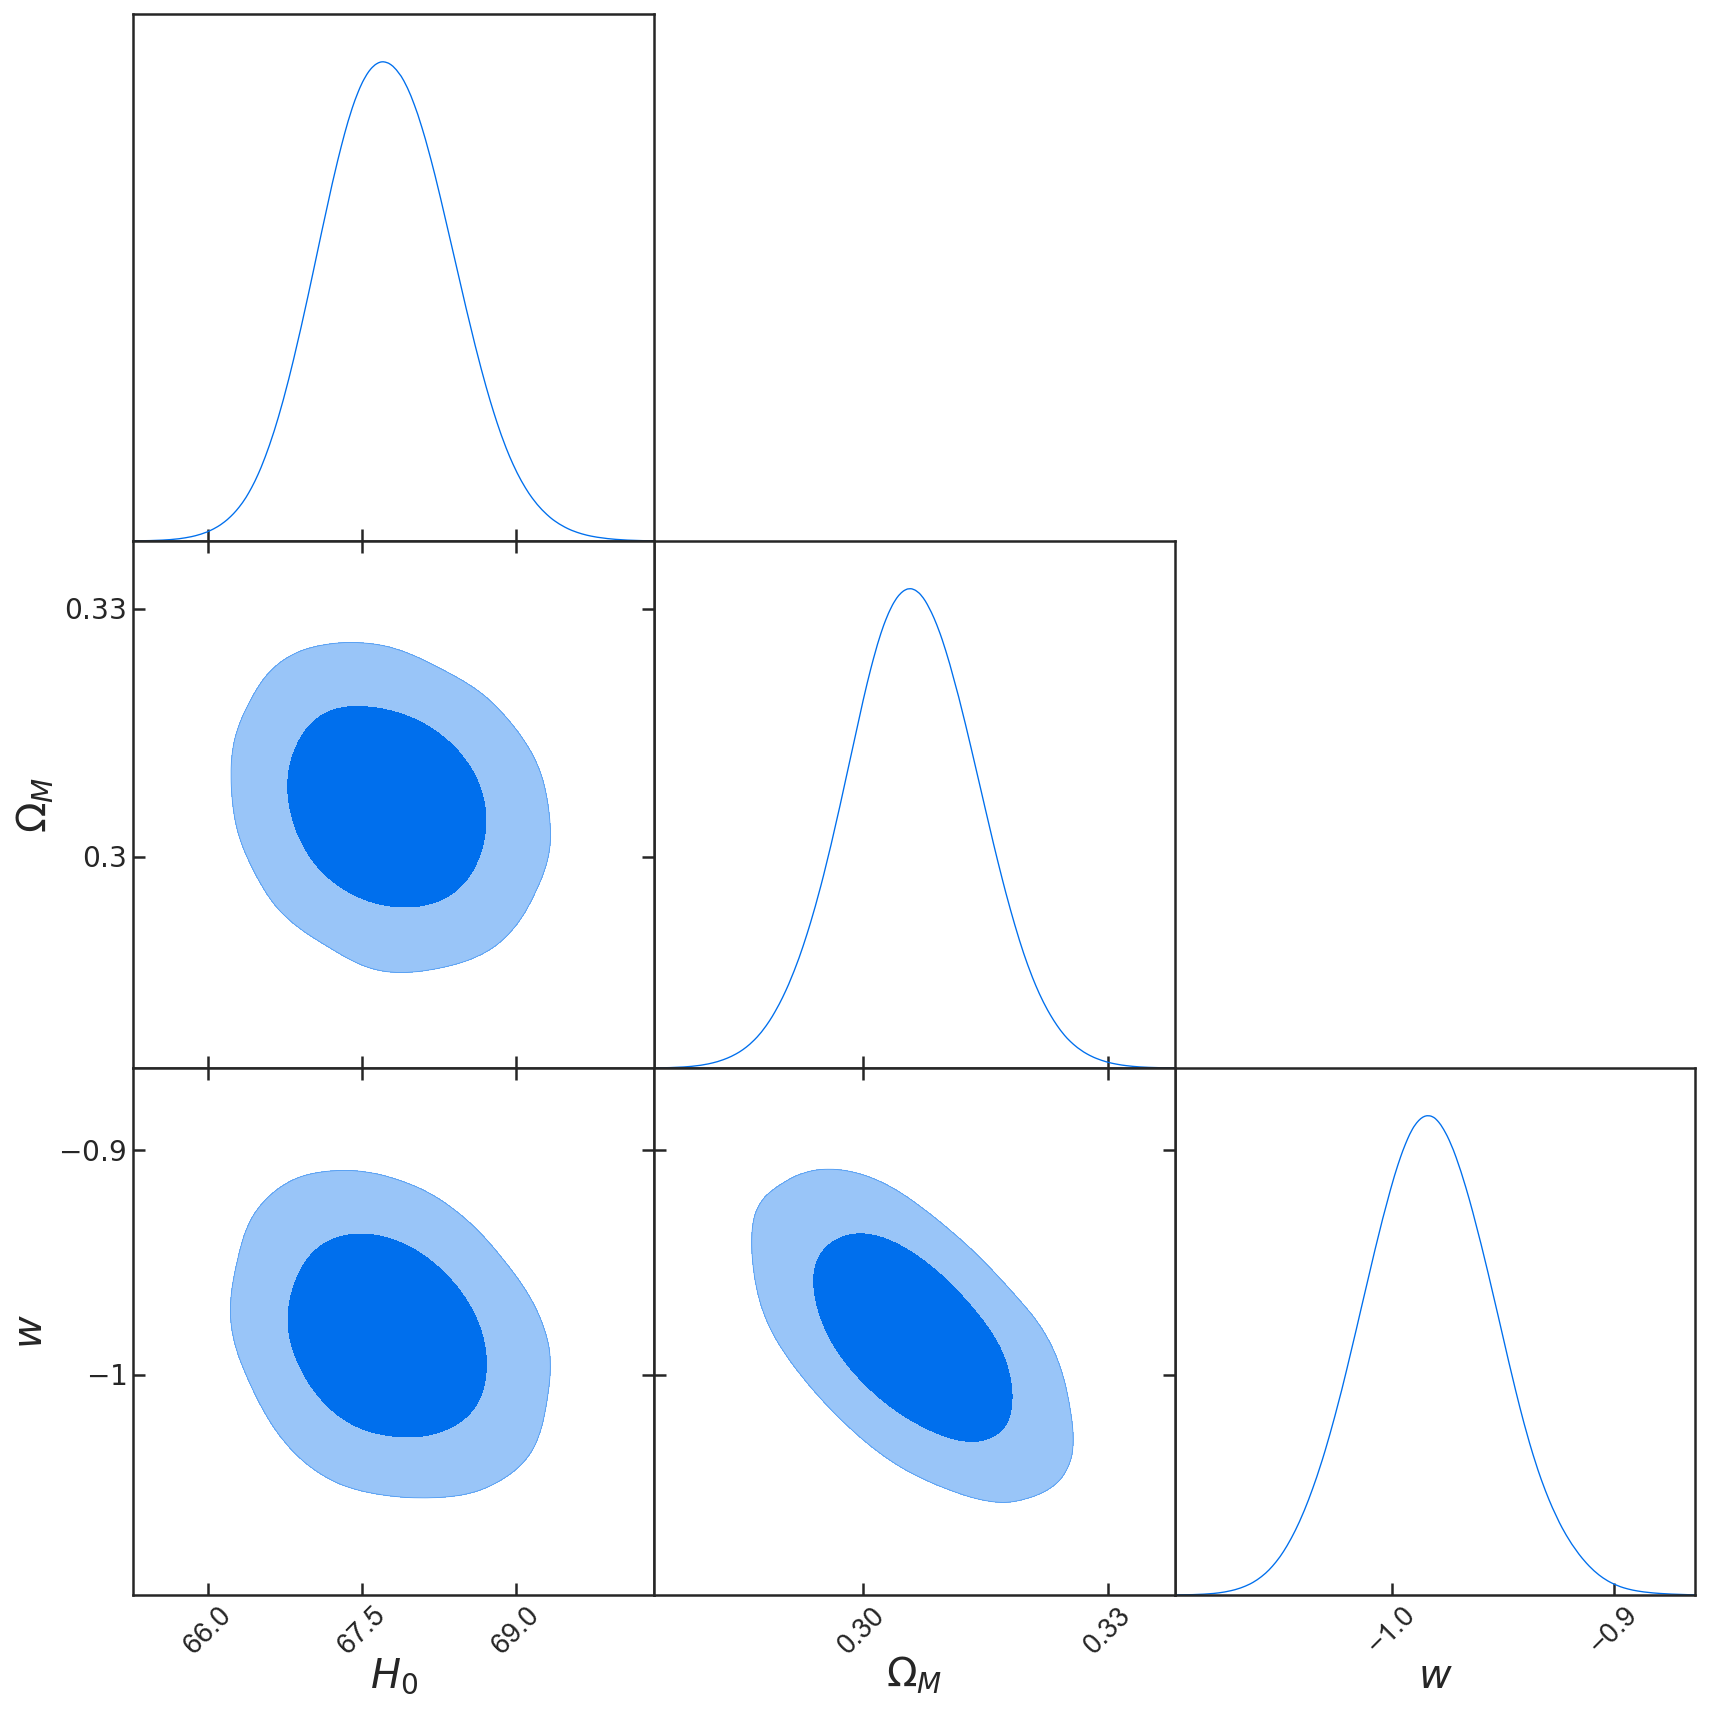

In [22]:
DelfiEnsemble.fisher_pretraining()

In [23]:
# Initial samples, batch size for population samples, number of populations
n_initial = 200
n_batch = 200
n_populations = 5

# Do the SNL training
DelfiEnsemble.sequential_training(simulator, compress, n_initial, n_batch, n_populations, patience=10,
                       save_intermediate_posteriors=True)

Sampling approximate posterior...
emcee: Exception while calling your likelihood function:
  params: [68.17826623  0.40811774 -1.40654573]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/wfarr/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/wfarr/anaconda3/lib/python3.7/site-packages/pydelfi-0.1-py3.7.egg/pydelfi/delfi.py", line 234, in log_posterior_stacked
    return self.log_likelihood_stacked(x) + self.prior.logpdf(x)
  File "/Users/wfarr/anaconda3/lib/python3.7/site-packages/pydelfi-0.1-py3.7.egg/pydelfi/delfi.py", line 221, in log_likelihood_stacked
    L += self.stacking_weights[n]*np.exp(self.nde[n].eval((np.atleast_2d((theta-self.p_mean)/self.p_std), np.atleast_2d((self.data-self.x_mean)/self.x_std)), self.sess))
  File "/Users/wfarr/anaconda3/lib/python3.7/site-packages/pydelfi-0.1-py3.7.egg/pydelfi/ndes.py", line 349, in eval
    lprob = sess.run(self.L,feed_dict={self.parameters:x,self.data:y})[0]
  File "/Users/wfarr/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 929, in run
    r

KeyboardInterrupt: 